# 0. Background

In logistics, a route between point A (factory, distribution centre, etc) and point B (customer) can be called a shipping lane. For large buiness, there can be many shipment origins and destinations that may result 100,000+ potential routes.

As it is challenging to remember the importance of each lane for the business, I was asked to create a model to categorize a shipping lane into several buckets. For example, shipping lane can be categorized as "High importance", "Medium Importance", "Low Importance" or "Special". I was provided with a sample of previously categorized lanes (labelled data points) and potential factors that affected the decisions (features).

The workflow was following:

Gather data for all routes using SQL.
Develop a Machine Learning model based on labelled data using Python.
Categorize all routes using the developed model and provide results to the operational team as a csv file.
Incorporate the results in existing Power BI reporting and refresh the model/re-apply lane cateogires every 3 month.
Note: the data used in the repository is made-up to avoid sharing corporate data. It is based on a real-life business case, so the approach can be applied to any business that is facing the same challenge.

# 1. Analyse data

In [1]:
#import python modules and data
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score

df_lab=pd.read_csv("LabelledInput.csv", index_col='Route')
df_lab['CustomerImportance'] = df_lab['CustomerImportance'] .astype(int)
df_lab.head(10)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


,ProductImportance,CustomerImportance,SpecialCase?,RouteCategory
Route,,,,
1,D,0,No,Low Importance
2,C,1,No,Medium Importance
3,C,0,No,Low Importance
4,E,1,Yes,Special
5,C,2,No,High Importance
6,A,2,No,High Importance
7,D,0,No,Low Importance
8,E,0,Yes,Special
9,E,1,No,Medium Importance


In [2]:
#review the dataframe #1
print("Summary:",'\n')
df_lab.info()

Summary: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 1 to 120
Data columns (total 4 columns):
ProductImportance     120 non-null object
CustomerImportance    120 non-null int32
SpecialCase?          120 non-null object
RouteCategory         120 non-null object
dtypes: int32(1), object(3)
memory usage: 4.2+ KB


In [3]:
#show possible values of features and labels:
print("RouteCategory/Label values:")
print(df_lab['RouteCategory'].value_counts())
print("\nProductImportance/feature1 values:")
print(df_lab['ProductImportance'].value_counts())
print("\nCustomerImportance/feature2 values:")
print(df_lab['CustomerImportance'].value_counts())
print("\nSpecialCase?/feature3 values:")
print(df_lab['SpecialCase?'].value_counts())

RouteCategory/Label values:
High Importance      49
Medium Importance    32
Low Importance       26
Special              13
Name: RouteCategory, dtype: int64

ProductImportance/feature1 values:
E    26
D    26
C    25
A    22
B    21
Name: ProductImportance, dtype: int64

CustomerImportance/feature2 values:
0    43
2    41
1    35
3     1
Name: CustomerImportance, dtype: int64

SpecialCase?/feature3 values:
No     107
Yes     13
Name: SpecialCase?, dtype: int64


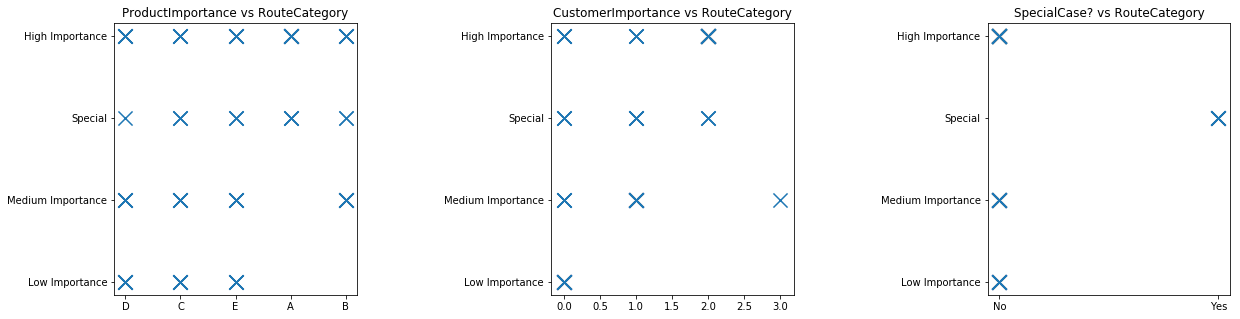

In [4]:
#visualise relationship between each feature and label
fig, axes=plt.subplots(nrows=1,ncols=3,figsize=(20,5))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.8, hspace=None)
axes[0].scatter(df_lab['ProductImportance'],df_lab['RouteCategory'],s=200, marker="x")
axes[0].set_title("ProductImportance vs RouteCategory")
axes[1].scatter(df_lab['CustomerImportance'],df_lab['RouteCategory'],s=200, marker="x")
axes[1].set_title("CustomerImportance vs RouteCategory")
axes[2].scatter(df_lab['SpecialCase?'],df_lab['RouteCategory'],s=200, marker="x")
axes[2].set_title("SpecialCase? vs RouteCategory")
plt.show();

Observations: "Special" route as exclusive for routes where "SpecialCase?" equals to "Yes".

# 2. Build the model using Logistic regression

We are working with categorical & numerical feature and with categorical labels. 
To ensure the Machine Learning algorith were working with our inputs, we will encode categorical data.  

In [5]:
#encode categorical data
columnsToEncode=df_lab.select_dtypes(include=[object]).columns
df_enc = pd.get_dummies(df_lab, columns=columnsToEncode)
df_enc.head()

,CustomerImportance,ProductImportance_A,ProductImportance_B,ProductImportance_C,ProductImportance_D,ProductImportance_E,SpecialCase?_No,SpecialCase?_Yes,RouteCategory_High Importance,RouteCategory_Low Importance,RouteCategory_Medium Importance,RouteCategory_Special
Route,,,,,,,,,,,,
1,0,0,0,0,1,0,1,0,0,1,0,0
2,1,0,0,1,0,0,1,0,0,0,1,0
3,0,0,0,1,0,0,1,0,0,1,0,0
4,1,0,0,0,0,1,0,1,0,0,0,1
5,2,0,0,1,0,0,1,0,1,0,0,0


In [6]:
#split data into train and test
features=df_enc.drop(['RouteCategory_High Importance','RouteCategory_Medium Importance','RouteCategory_Low Importance','RouteCategory_Special'],axis=1)
labels=df_enc[['RouteCategory_High Importance','RouteCategory_Medium Importance','RouteCategory_Low Importance','RouteCategory_Special']]
X_train, X_test, y_train, y_test=train_test_split(features, labels, test_size=0.3, random_state=1)

In [7]:
#build the Logistics regression model function
def logar_model(X_train, y_train):
    lr=LogisticRegression()
    parameters={
        "C":[0.001,0.005,0.01,0.05,1,5,10,50,100],
    }
    cv=GridSearchCV(lr,parameters, cv=5)
    cv.fit(X_train, y_train)
    lr_model=cv.best_estimator_
    return lr_model

#create the Logistics regression model for each type of lane
log_high_model=logar_model(X_train, y_train['RouteCategory_High Importance'])
log_med_model=logar_model(X_train, y_train['RouteCategory_Medium Importance'])
log_low_model=logar_model(X_train, y_train['RouteCategory_Low Importance'])
log_sp_model=logar_model(X_train, y_train['RouteCategory_Special'])

# 3. Build the model using Random Forest

In [8]:
#build the Random Forest model function
def rf_model(X_train, y_train):
    rf=RandomForestClassifier()
    parameters={
    "n_estimators":[5,25,125],
    "max_depth":[2,8,16]
    }
    cv=GridSearchCV(rf,parameters, cv=5)
    cv.fit(X_train, y_train)
    rf_model=cv.best_estimator_
    return rf_model

#create the Random Forest model for each type of lane
rf_high_model=rf_model(X_train, y_train['RouteCategory_High Importance'])
rf_med_model=rf_model(X_train, y_train['RouteCategory_Medium Importance'])
rf_low_model=rf_model(X_train, y_train['RouteCategory_Low Importance'])
rf_sp_model=rf_model(X_train, y_train['RouteCategory_Special'])

# 4. Compare results of Logistics Regression and Random Forest models

In [9]:
#build "measure the results" function
def performance_results(model,y_test):  
    pred=model.predict(X_test)
    accuracy=accuracy_score(y_test,pred)
    precision=precision_score(y_test,pred)
    recall=recall_score(y_test,pred)
    return accuracy,precision,recall

#measure the Logistics Regression results for each type of lane
print("Logistics Regression results:")
print("High Importance route results (accuracy,precision,recall) =", performance_results(log_high_model,y_test['RouteCategory_High Importance']))
print("Med Importance route results (accuracy,precision,recall) =", performance_results(log_med_model,y_test['RouteCategory_Medium Importance']))
print("Low Importance route results (accuracy,precision,recall) =", performance_results(log_low_model,y_test['RouteCategory_Low Importance']))
print("Special Importance route results (accuracy,precision,recall) =", performance_results(log_sp_model,y_test['RouteCategory_Special']))

#measure the Random Forest Regression results for each type of lane
print("\nRandom Forest Regression results:")
print("High Importance route results (accuracy,precision,recall) =", performance_results(rf_high_model,y_test['RouteCategory_High Importance']))
print("Med Importance route results (accuracy,precision,recall) =", performance_results(rf_med_model,y_test['RouteCategory_Medium Importance']))
print("Low Importance route results (accuracy,precision,recall) =", performance_results(rf_low_model,y_test['RouteCategory_Low Importance']))
print("Special Importance route results (accuracy,precision,recall) =", performance_results(rf_sp_model,y_test['RouteCategory_Special']))

Logistics Regression results:
High Importance route results (accuracy,precision,recall) = (1.0, 1.0, 1.0)
Med Importance route results (accuracy,precision,recall) = (0.6944444444444444, 0.5714285714285714, 0.3333333333333333)
Low Importance route results (accuracy,precision,recall) = (1.0, 1.0, 1.0)
Special Importance route results (accuracy,precision,recall) = (1.0, 1.0, 1.0)

Random Forest Regression results:
High Importance route results (accuracy,precision,recall) = (1.0, 1.0, 1.0)
Med Importance route results (accuracy,precision,recall) = (1.0, 1.0, 1.0)
Low Importance route results (accuracy,precision,recall) = (1.0, 1.0, 1.0)
Special Importance route results (accuracy,precision,recall) = (1.0, 1.0, 1.0)


Results between both algorithms are the same, except of Medium Importance lane. Logistic regression is underperforming for Medium Importance lane compared to Random Forest

Logistics Regression model coefficients


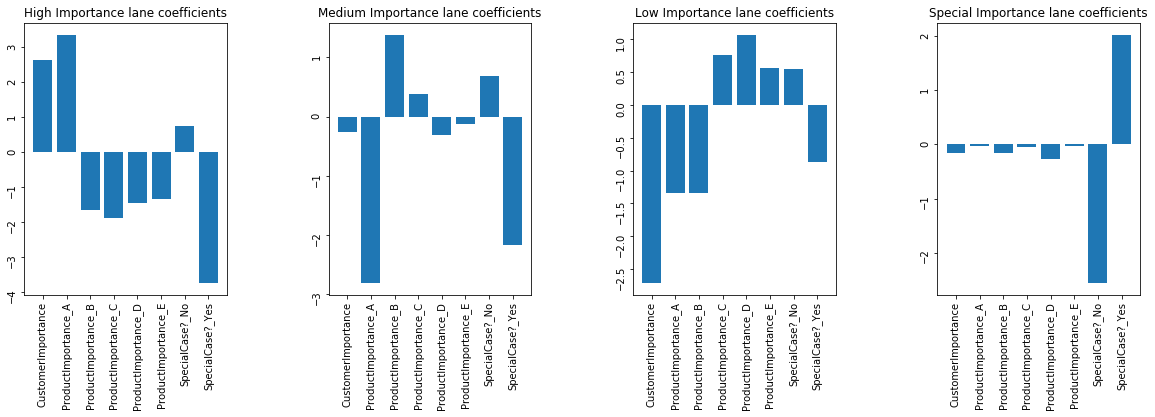

In [10]:
#plot importance on features for Logistic Regression 
print("Logistics Regression model coefficients")
fig, axes=plt.subplots(nrows=1,ncols=4,figsize=(20,5))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
axes[0].bar(X_train.columns,log_high_model.coef_[0])
axes[0].tick_params(labelrotation=90)
axes[0].set_title("High Importance lane coefficients")
axes[1].bar(X_train.columns,log_med_model.coef_[0])
axes[1].tick_params(labelrotation=90)
axes[1].set_title("Medium Importance lane coefficients")
axes[2].bar(X_train.columns,log_low_model.coef_[0])
axes[2].tick_params(labelrotation=90)
axes[2].set_title("Low Importance lane coefficients")
axes[3].bar(X_train.columns,log_sp_model.coef_[0])
axes[3].tick_params(labelrotation=90)
axes[3].set_title("Special Importance lane coefficients")
plt.show();

Logistics Regression model feature importance


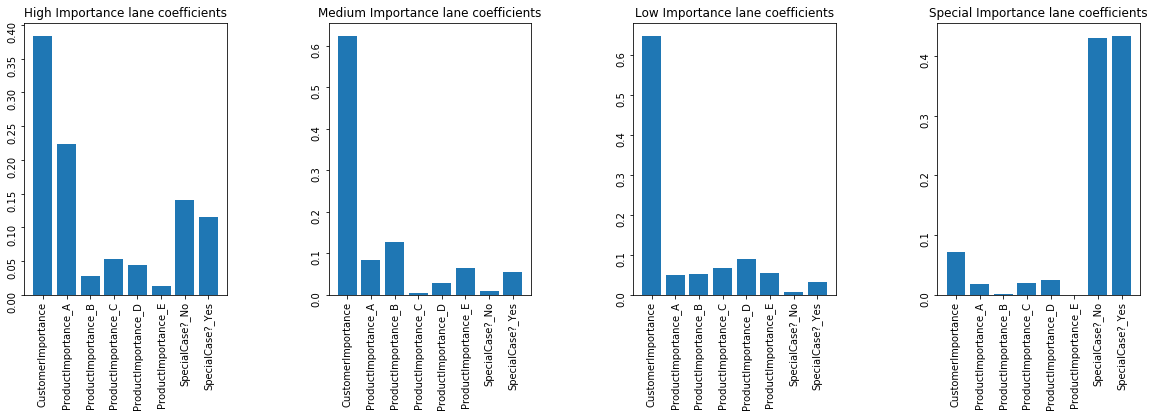

In [11]:
#plot importance on features for Random Forest
print("Logistics Regression model feature importance")
fig, axes=plt.subplots(nrows=1,ncols=4,figsize=(20,5))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
axes[0].bar(X_train.columns,rf_high_model.feature_importances_)
axes[0].tick_params(labelrotation=90)
axes[0].set_title("High Importance lane coefficients")
axes[1].bar(X_train.columns,rf_med_model.feature_importances_)
axes[1].tick_params(labelrotation=90)
axes[1].set_title("Medium Importance lane coefficients")
axes[2].bar(X_train.columns,rf_low_model.feature_importances_)
axes[2].tick_params(labelrotation=90)
axes[2].set_title("Low Importance lane coefficients")
axes[3].bar(X_train.columns,rf_sp_model.feature_importances_)
axes[3].tick_params(labelrotation=90)
axes[3].set_title("Special Importance lane coefficients")
plt.show();

# 5. Submit results

In [13]:
#load the Unlabelled data and get it ready for model
df_res=pd.read_csv("UnlabelledInput.csv", index_col='Route')
df_res['CustomerImportance'] = df_res['CustomerImportance'] .astype(int)
columnsToEncode=df_res.select_dtypes(include=[object]).columns
df_res = pd.get_dummies(df_res, columns=columnsToEncode)

#apply model
high_lane_subm=rf_high_model.predict(df_res)
med_lane_subm=rf_med_model.predict(df_res)
low_lane_subm=rf_low_model.predict(df_res)
sp_lane_subm=rf_sp_model.predict(df_res)

#add columns with results from out models
df_res['RouteCategory_High Importance']=high_lane_subm
df_res['RouteCategory_Medium Importance']=med_lane_subm
df_res['RouteCategory_Low Importance']=low_lane_subm
df_res['RouteCategory_Special']=sp_lane_subm

#Merge 4 route columsn into one
df_res=df_res[['RouteCategory_High Importance','RouteCategory_Medium Importance','RouteCategory_Low Importance','RouteCategory_Special']].idxmax(axis=1)
df_res=df_res.to_frame(name='RouteCategory')
df_res['RouteCategory']=df_res['RouteCategory'].apply(lambda x:x.split('_')[1])

df_res.to_csv("Output.csv", index=True)
df_res.head(10)

,RouteCategory
Route,
1,High Importance
2,High Importance
3,Medium Importance
4,Special
5,High Importance
6,Low Importance
7,Low Importance
8,Medium Importance
9,Special
